# Data Science Foundations <br> X4: Spotify

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

Prompt: What makes a playlist successful? 

<br>

---

## Data Description



| Column Name             | Description                                                                                              |
|-------------------------|----------------------------------------------------------------------------------------------------------|
| playlist_uri            | The key, Spotify uri of the playlist                                                                     |
| owner                   | Playlist owner, Spotify username                                                                         |
| streams                 | Number of streams from the playlist today                                                                |
| stream30s               | Number of streams over 30 seconds from playlist today                                                    |
| dau                     | Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today               |
| wau                     | Number of Weekly Active Users, i.e. users with a stream over 30 seconds from playlist in past week       |
| mau                     | Number of Monthly Active Users, i.e. users with a stream over 30 seconds from playlist in the past month |
| mau_previous_months     | Number of Monthly Active users in the month prior to this one                                            |
| mau_both_months         | Number of users that were active on the playlist both this and the previous month                        |
| users                   | Number of users streaming (all streams) from this playlist this month                                    |
| skippers                | Number of users who skipped more than 90 percent of their streams today                                  |
| owner_country           | Country of the playlist owner                                                                            |
| n_tracks                | Number of tracks in playlist                                                                             |
| n_local_tracks          | Change in number of tracks on playlist since yesterday                                                   |
| n_artists               | Number of unique artists in playlist                                                                     |
| n_albums                | Number of unique albums in playlist                                                                      |
| monthly_stream30s       | Number of streams over 30 seconds this month                                                             |
| monthly_owner_stream30s | Number of streams over 30 seconds by playlist owner this month                                           |
| tokens                  | List of playlist title tokens, stopwords and punctuation removed                                         |
| genre_1                 | No. 1 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| genre_2                 | No. 2 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| genre_3                 | No. 3 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| mood_1                  | No. 1 Mood by weight of playlist tracks, from Gracenote metadata                                         |
| mood_2                  | No. 2 Mood by weight of playlist tracks, from Gracenote metadata                                         |
| mood_3                  | No. 3 Mood by weight of playlist tracks, from Gracenote metadata                                         |

## Imports

In [2]:
# basic packages
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import random
import copy

# visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import graphviz 

# stats packages
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

# sklearn modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture

# sklearn evaluation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score


In [3]:
df = pd.read_csv("../../data/playlist_summary_external-4.txt", delimiter='\t')

## Dependency

In [4]:
sub_targets = ['mau_previous_month', 'mau_both_months', 'monthly_stream30s', 'stream30s']
# sub_targets = ['mau', 'dau', 'monthly_stream30s', 'stream30s']

des_features = ['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']
con_features = ['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']
df['success'] = df[sub_targets].apply(lambda x: x > np.quantile(x, 0.75)).all(axis=1)

df['listen_conversions'] = df['stream30s'] / df['streams']
df['listen_conversions'].fillna(value=0, inplace=True)

df['user_retention'] = df['mau_both_months'] / df['mau_previous_month']
df['user_retention'].fillna(value=0, inplace=True)

df['user_conversions'] = df['mau'] / df['users']
df['user_conversions'].fillna(value=0, inplace=True)


df['mau_growing'] = df['mau'] > df['mau_previous_month']
df['mau_growth'] = df['mau'] / df['mau_previous_month']
df['mau_growth'].fillna(value=0, inplace=True)
df['mau_growth'].replace([np.inf, -np.inf], 1, inplace=True)

new_metrics = ['listen_conversions', 'user_conversions', 'user_retention', 'mau_growth']

df['new_success'] = df[new_metrics].apply(lambda x: (x > 0.5) if (max(x) == 1) else (x > 1)).all(axis=1)

### Discrete

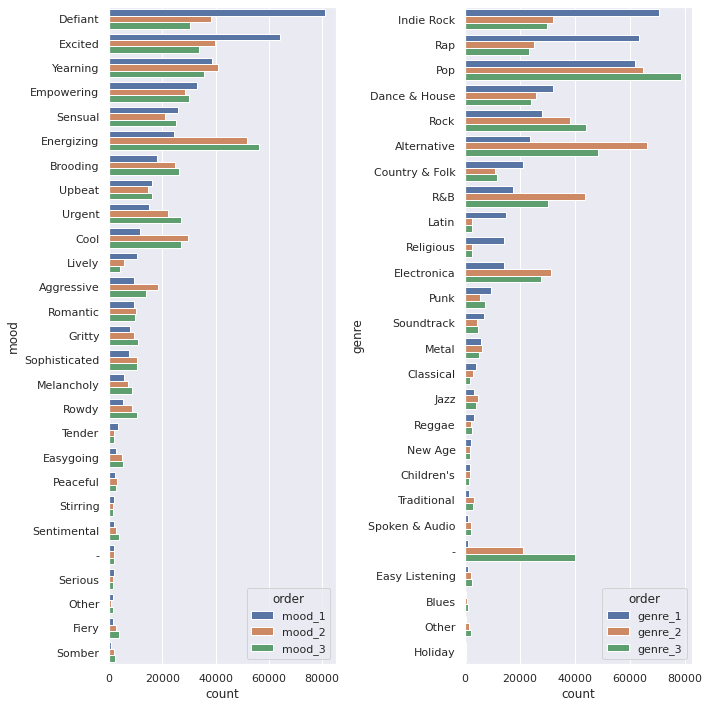

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

dff = pd.DataFrame(df[des_features[0]].value_counts()).join(
    pd.DataFrame(df[des_features[1]].value_counts())).join(
    pd.DataFrame(df[des_features[2]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['mood', 'order', 'count']
sns.barplot(data=dff, hue='order', y='mood', x='count', orient='h', ax=ax[0])

dff = pd.DataFrame(df[des_features[3]].value_counts()).join(
    pd.DataFrame(df[des_features[4]].value_counts())).join(
    pd.DataFrame(df[des_features[5]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['genre', 'order', 'count']
sns.barplot(data=dff, hue='order', y='genre', x='count', orient='h', ax=ax[1])

plt.tight_layout()
fig.savefig("discrete_rank_bar_plot.svg")

In [9]:
def make_chisum(target='success'):
    
    chidf = pd.DataFrame()
    chidf[target] = df[target]
    chisum = pd.DataFrame()
    cutoff = 0.01
    pop = chidf[target].values

    for ind in des_features:
        chidf[ind] = df[ind]

        for grp_label in df[ind].unique():
            try:
                cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
                chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
                ratio = cTable[1]/cTable[0]
                pos = ratio[1]/ratio[0]
                chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
            except:
                pass

    chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
    chisum = chisum.sort_values('p-value').reset_index(drop=True)
    
    return chisum

def make_cat_plots(target='success', ind_feature='genre_1'):
    fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col', sharey='row')


    genre_list = chisum.loc[(chisum['feature'] == ind_feature)
                           & (chisum['reject null'] == True)].sort_values('multiplier', ascending=False)['group'].values

    dff = pd.DataFrame(df.groupby([ind_feature])[target].value_counts(sort=False))
    dff.columns = ['percent']
    dff = dff.reset_index()
    dff.loc[dff[target] == True, 'percent'] = dff.loc[dff[target] == True, 'percent'] / dff.loc[dff[target] == True, 'percent'].sum() 
    dff.loc[dff[target] == False, 'percent'] = dff.loc[dff[target] == False, 'percent'] / dff.loc[dff[target] == False, 'percent'].sum() 
    dff = dff.set_index(ind_feature).loc[genre_list,:]
    dff = dff.reset_index()

    sns.barplot(data=dff.iloc[:10,:], hue=target, y=ind_feature, x='percent', ax=ax[0,0])
    ax[0,0].set_title('Best  and Worst Genres, Percent')
    ax[0,0].set_ylabel('')
    ax[0,0].set_xlabel('')
    sns.barplot(data=dff.iloc[-10:,:], hue=target, y=ind_feature, x='percent', ax=ax[1,0])
    ax[1,0].set_ylabel('')

    dff = pd.DataFrame(df.groupby([ind_feature])[target].value_counts(sort=False))
    dff.columns = ['count']
    dff = dff.reset_index()
    dff = dff.set_index(ind_feature).loc[genre_list,:]
    dff = dff.reset_index()

    sns.barplot(data=dff.iloc[:10,:], hue=target, y=ind_feature, x='count', ax=ax[0,1])
    ax[0,1].set_title('Best and Worst Genres, Count')
    ax[0,1].set_ylabel('')
    ax[0,1].set_xlabel('')
    sns.barplot(data=dff.iloc[-10:,:], hue=target, y=ind_feature, x='count', ax=ax[1,1])
    ax[1,1].set_ylabel('')
    plt.tight_layout()

    ax[0,0].get_legend().remove()
    ax[1,1].get_legend().remove()
    ax[1,0].get_legend().remove()
    ax[0,1].legend(framealpha=1, facecolor='white', title="Success")
    
    return fig

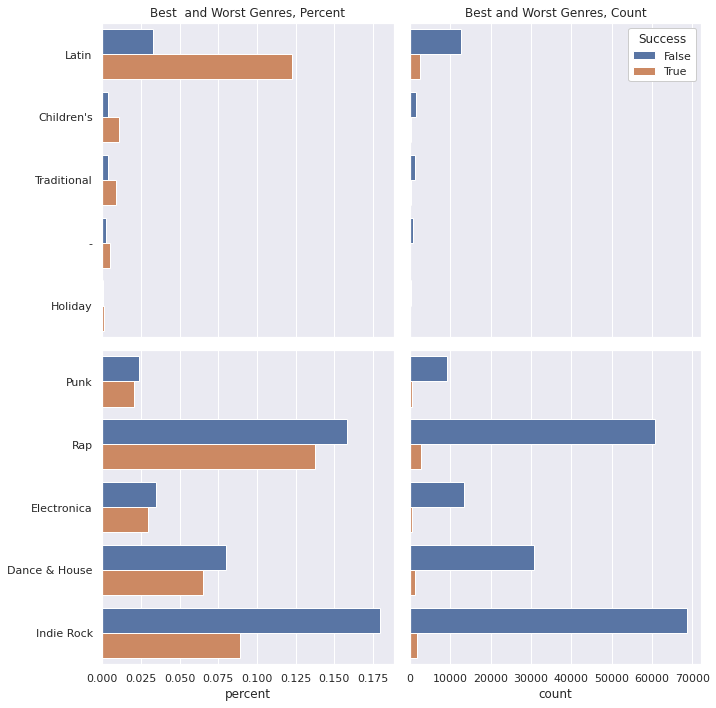

In [33]:
ind_feature = 'genre_1'
target = 'success'

chisum = make_chisum(target)
fig = make_cat_plots(target, ind_feature)

chisum.loc[(chisum['feature'] == ind_feature)
        & (chisum['reject null'] == True)].sort_values('multiplier', 
           ascending=False).to_excel(f'{target}_{ind_feature}_categorical.xlsx')

fig.savefig(f"{target}_{ind_feature}_categorical.svg")

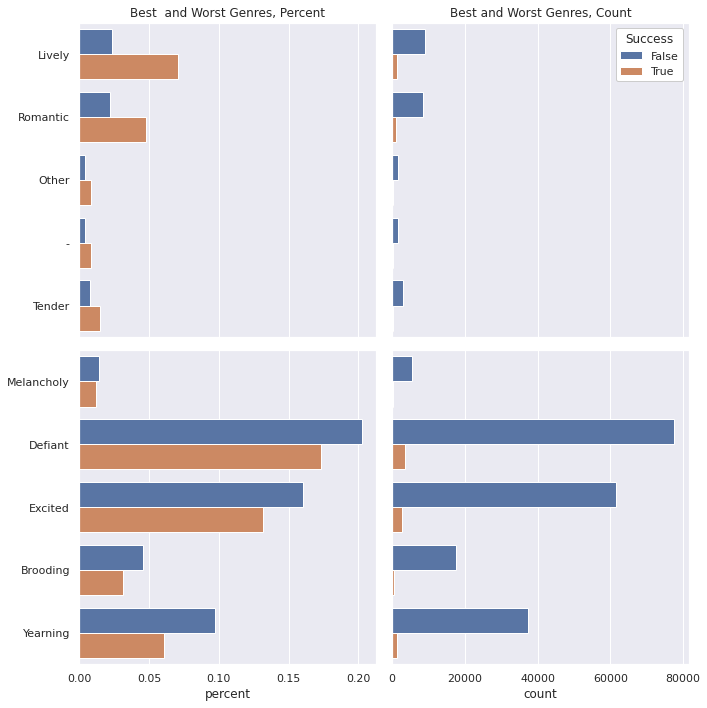

In [34]:
ind_feature = 'mood_1'
target = 'success'

chisum = make_chisum(target)
fig = make_cat_plots(target, ind_feature)

chisum.loc[(chisum['feature'] == ind_feature)
        & (chisum['reject null'] == True)].sort_values('multiplier', 
           ascending=False).to_excel(f'{target}_{ind_feature}_categorical.xlsx')

fig.savefig(f"{target}_{ind_feature}_categorical.svg")

### Continuous

In [13]:
def make_con_plots(target, con_features):
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
    chidf = pd.DataFrame()
    chidf[target] = df[target]
    welchsum = pd.DataFrame()
    cutoff = 0.01
    pop = chidf[target].values

    for ind, ax in zip(con_features, [ax1, ax2, ax3, ax4]):
        chidf[ind] = df[ind]
        a = []
        b = []
        for i in range(100):
            boot1 = random.sample(
                        list(
                            chidf.loc[
                                (chidf[target] == True)
                            ][ind].values),
                        k=1000)
            boot2 = random.sample(
                        list(
                            chidf.loc[
                                (chidf[target] == False)
                            ][ind].values),
                        k=1000)
            a.append(np.mean(boot1))
            b.append(np.mean(boot2))
        testt, p = stats.ttest_ind(a, b, equal_var=False)
        a_avg = np.mean(a)
        b_avg = np.mean(b)
        welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
        sns.histplot(a, color='tab:orange', label=f"{target} == True", ax=ax)
        sns.histplot(b, label=f"{target} == False", ax=ax)
        ax.set_title(ind)

    welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
    welchsum = welchsum.sort_values('p-value').reset_index(drop=True)
    ax.legend()
    
    return fig, welchsum

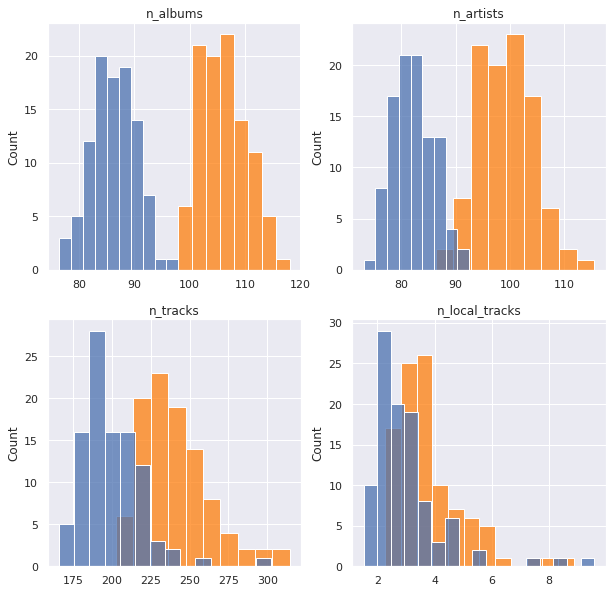

In [19]:
target = 'new_success'

fig, welchsum = make_con_plots(target, con_features)

welchsum.to_excel(f"{target}_continuous.xlsx")
fig.savefig(f"{target}_ttest.svg")

## Models

### Logistic Regression

In [14]:
### y
target = "success"
print(target)
y = df[target].values

#### X
X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()
X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((np.ones((X_con.shape[0], 1)), X_con, X_cat))
feature_names = ['intercept'] + con_features + list(enc.get_feature_names_out())

data = pd.DataFrame(X, columns=feature_names)

success


In [21]:
def add_feature(feature_names, basemodel, data, y, r2max=0, model='linear', disp=0):
    feature_max = None
    bestsum = None
    newmodel = None
    for feature in feature_names:
        basemodel[feature] = data[feature]
        X2 = basemodel.values
        est = Logit(y, X2)
        est2 = est.fit(disp=0)
        summ = est2.summary()
        score = float(str(pd.DataFrame(summ.tables[0]).loc[3, 3]))
        if (score > r2max) and not (est2.pvalues > cutoff).any():
            r2max = score
            feature_max = feature
            bestsum = est2.summary()
            newmodel = basemodel.copy()
            if disp == 1:
                print(f"new r2max, {feature_max}, {r2max}")
        basemodel.drop(labels = feature, axis = 1, inplace = True)
    return r2max, feature_max, bestsum, newmodel

In [22]:
candidates = feature_names.copy()
basemodel = pd.DataFrame()
r2max = 0

In [ ]:
while True:
    newr2max, feature_max, bestsum, newmodel = add_feature(
        feature_names=candidates, 
        basemodel=basemodel, 
        data=data, 
        y=y,
        r2max=r2max)    
    if newr2max > r2max:
        r2max = newr2max
        print(f"new r2max, {feature_max}, {r2max}")
        with open("success_fwd_selection_results.txt", "a+") as f:
            file_data = f.read()
            f.write(f"new r2max, {feature_max}, {r2max}\n")
        candidates.remove(feature_max)
        with open("success_canidates.txt", "w+") as f:
            file_data = f.read()
            for i in candidates:
                f.write(f"{i}\n")
        basemodel = newmodel
        basemodel.to_csv("success_basemodel.csv")
        continue
    else:
        break

In [26]:
basemodel = pd.read_csv("success_basemodel.csv", index_col = 0)
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
display(res_df)
res_df.to_excel("success_log.xlsx")

In [29]:
### y
target = "monthly_stream30s"
print(target)
y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = 0
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              & (labels <= np.quantile(y, quant))] = 1
        weights[(y > np.quantile(y, prev))
              & (y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

basemodel = pd.read_csv("../../scripts/basemodel.csv", index_col = 0)
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
display(res_df)
res_df.to_excel("log_model_monthly_stream30s.xlsx")

monthly_stream30s


,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-2.0737,0.016,-133.150,0.000,-2.104,-2.043
n_albums,0.2656,0.012,21.287,0.000,0.241,0.290
genre_1_Latin,0.5408,0.027,19.906,0.000,0.488,0.594
genre_1_Indie Rock,-0.5832,0.020,-28.964,0.000,-0.623,-0.544
genre_1_Rap,-0.3259,0.020,-16.697,0.000,-0.364,-0.288
genre_1_Dance & House,-0.3034,0.027,-11.069,0.000,-0.357,-0.250
genre_1_Rock,-0.4226,0.025,-16.996,0.000,-0.471,-0.374
mood_1_Energizing,-0.2844,0.027,-10.670,0.000,-0.337,-0.232
genre_1_Children's,0.7845,0.062,12.608,0.000,0.663,0.906
mood_1_Tender,0.4943,0.055,9.032,0.000,0.387,0.602


In [31]:
summ.tables[0]

Dep. Variable:,y,No. Observations:,403366
Model:,Logit,Df Residuals:,403309
Method:,MLE,Df Model:,56
Date:,"Sun, 24 Apr 2022",Pseudo R-squ.:,0.04795
Time:,18:07:32,Log-Likelihood:,-1.2475e+05
converged:,True,LL-Null:,-1.3104e+05
Covariance Type:,nonrobust,LLR p-value:,0.000


In [6]:
basemodel = pd.read_csv("../../scripts/new_basemodel.csv", index_col = 0)
y = df['new_success']
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
display(res_df)
res_df.to_excel("new_success_log_model.xlsx")

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-2.4336,0.012,-201.725,0.000,-2.457,-2.410
genre_3_-,-0.6766,0.025,-27.158,0.000,-0.725,-0.628
n_albums,0.1399,0.015,9.597,0.000,0.111,0.169
genre_1_Indie Rock,0.2702,0.016,17.240,0.000,0.240,0.301
mood_1_Defiant,0.2505,0.018,14.035,0.000,0.215,0.285
genre_1_Dance & House,0.3042,0.021,14.388,0.000,0.263,0.346
mood_1_Excited,0.1917,0.017,11.607,0.000,0.159,0.224
mood_1_Upbeat,0.2698,0.028,9.713,0.000,0.215,0.324
genre_2_Indie Rock,0.1527,0.019,7.854,0.000,0.115,0.191
genre_1_Rap,0.1876,0.019,9.843,0.000,0.150,0.225
